## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime as dtz
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## funciones

In [2]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad = math.pi/180
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6372.795477598 # km radio de la tierra
    a = (math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    dist = 2*R*math.asin(math.sqrt(a))
    return dist

In [3]:
# Funcion que ingresa dos array de igual tama;o y positivos
# Funciones deben ir de lo mas profundo a lo mas somero (se deben dar vuelta si no es asi)
def phi_1(z, rho):
    g = 9.81
    l = len(z)
    sum_rho_hat = 0
    sum_pot = 0
    for i in range(l):
        if i == 0:
            sum_rho_hat += rho[i]*z[i]
        else:
            sum_rho_hat += rho[i]*(z[i] - z[i-1])
    rho_hat = sum_rho_hat/z[l-1]
    for j in range(l):
        if j == 0:
            sum_pot += (rho[j]-rho_hat)*z[j]**2
        else:
            sum_pot += (rho_hat - rho[j])*(z[j-1]**2 - z[j]**2)
    pot = (g/(2*z[l-1]))*sum_pot
    return rho_hat, pot 

def phi_2(z, rho):
    g = 9.81
    l = len(z)
    sum_rho_hat = 0
    sum_pot = 0
    for i in range(l):
        if i == 0:
            sum_rho_hat += 0.5*rho[i]*(z[i] + z[i+1])
        elif i == l-1:
            sum_rho_hat += rho[i]*(z[i] - 0.5*(z[i-1] + z[i]))
        else:
            sum_rho_hat += 0.5*rho[i]*(-z[i-1] + z[i+1])
    rho_hat = sum_rho_hat/z[l-1]
    for j in range(l):
        if j == 0:
            sum_pot += (rho[j]-rho_hat)*0.25*(z[j]+z[j+1])**2
        elif j == l-1:
            sum_pot += (rho_hat-rho[j])*(0.25*(z[j-1]+z[j])**2 - z[j]**2)
        else:
            sum_pot += 0.25*(rho_hat-rho[j])*((z[j-1] + z[j])**2 - (z[j]+z[j+1])**2)
    pot = (g/(2*z[l-1]))*sum_pot
    return rho_hat, pot 

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

## importar datos

In [6]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

# DC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
# NM = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
# ML = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
# PC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [7]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [8]:
prof1 = sio.loadmat("data/018517_20120217_1505_data.mat")
RBR = prof1["RBR"]
datetime = prof1['datetime']
datos = prof1['datos']
names = prof1['names']
units = prof1['units']

In [9]:
names2 = np.empty(9, dtype=object)
for i in range(0,9):
    names2[i] = names[i][0][0]

datetime2 = np.empty(len(datetime), dtype='U25')
for i in range(0,len(datetime)):
    datetime2[i] = datetime[i][0][0]


In [10]:
data = pd.DataFrame(datos, index=pd.to_datetime(datetime2, format='%Y-%m-%d %H:%M:%S'), columns=names2)

## Densidad

In [11]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['Density'] = rho_dc1
DC_2['Density'] = rho_dc2
DC_3['Density'] = rho_dc3
DC_4['Density'] = rho_dc4

In [12]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['Density'] = rho_nm1
NM_2['Density'] = rho_nm2
NM_3['Density'] = rho_nm3

In [13]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['Density'] = rho_ml1
ML_2['Density'] = rho_ml2

In [14]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['Density'] = rho_pc

In [15]:
data["Density"] = to_density(z=data["Depth"], sal=data["Salinity"], temp=data["Temperature"], lat=37.26)

## Locations

In [16]:
# lon = np.array([[-122.408351,
#                   -122.408351,
#                   -122.408392,
#                   -122,408409,
#                   -122,408414,
#                   -122.408350, 
#                   -122.408380,
#                   -122.407306, 
#                   -122.407306]])
points = np.array([[37.263298, -122.408351],
                  [37.263285, -122.408392],
                  [37.263284, -122.408409],
                  [37.263285, -122.408414],
                  [37.263312, -122.408350], 
                  [37.263308, -122.408380],
                  [37.263967, -122.407306], 
                  [37.263967, -122.407306],
                  [37.263362, -122.409570],
                  [37.263324, -122.409648],
                  [37.263855, -122.410244],
                  [37.263927, -122.410261], 
                  [37.263951, -122.410299],
                  [37.263970, -122.410316],
                  [37.263910, -122.410233],
                  [37.263938, -122.410275],
                  [37.263967, -122.410300], 
                  [37.264042, -122.410328], 
                  [37.264626, -122.410336], 
                  [37.264742, -122.410434],
                  [37.265546, -122.410892], 
                  [37.265557, -122.410907], 
                  [37.265549, -122.410926], 
                  [37.265589, -122.410924], 
                  [37.265629, -122.410901], 
                  [37.265719, -122.410819], 
                  [37.265727, -122.410812],
                  [37.265724, -122.410804],
                  [37.264861111, -122.410527778], #ML
                  [37.264055556, -122.410333333], #DC
                  [37.265888889, -122.411027778], #NM
                  [37.264111111, -122.406000000]])  #PC



df = pd.DataFrame(points, columns=['Latitud', 'Longitud'])

In [17]:
data.index = data.index + dtz.timedelta(hours=3) # OJO: correr una sola vez

# Figuras

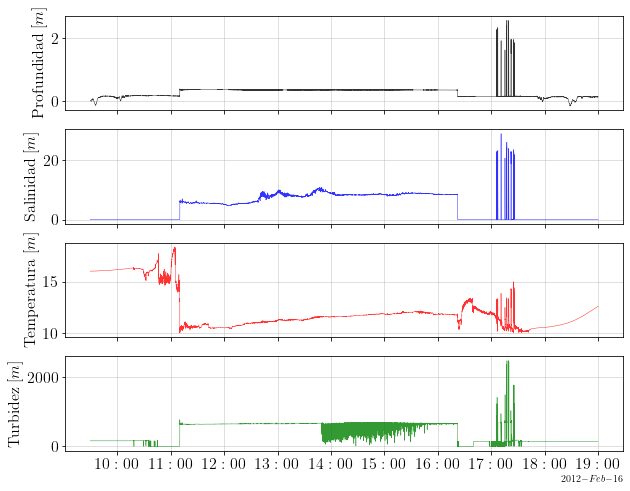

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 8), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(data.index, data['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax2.plot(data.index, data['Salinity'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax3.set_ylabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax3.plot(data.index, data['Temperature'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=16)

ax4.plot(data.index, data['Turbidity'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [19]:
data_cut = data.loc[dtz.datetime(2012,2,16,8,10,0):dtz.datetime(2012,2,16,13,25,0)]

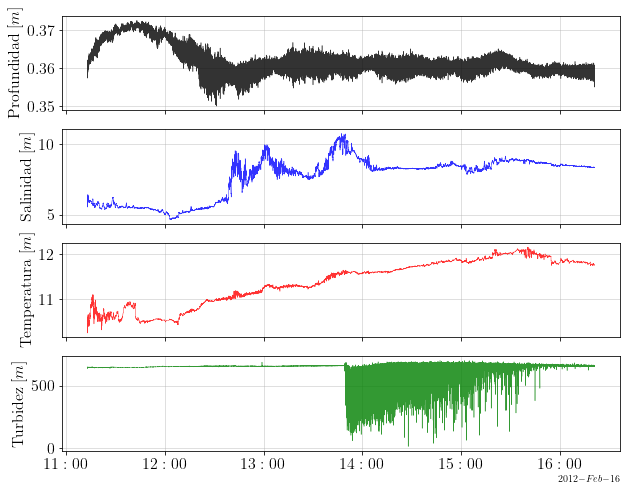

In [20]:
data_cut = data.iloc[37000:148000]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 8), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(data_cut.index, data_cut['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax2.plot(data_cut.index, data_cut['Salinity'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax3.set_ylabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax3.plot(data_cut.index, data_cut['Temperature'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=16)

ax4.plot(data_cut.index, data_cut['Turbidity'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

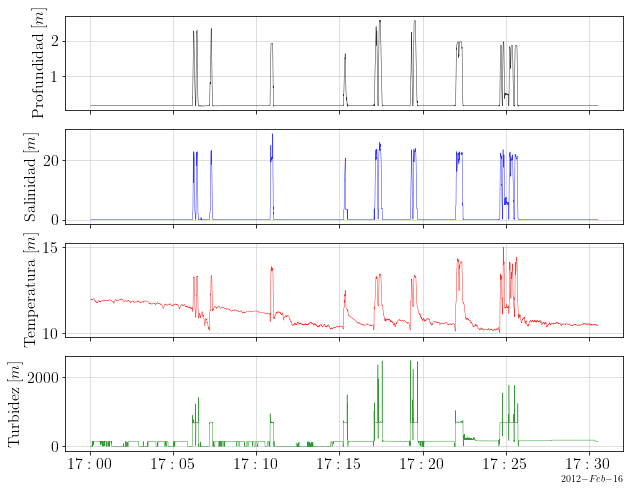

In [21]:
data_cut = data.iloc[162000:173000]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 8), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(data_cut.index, data_cut['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax2.plot(data_cut.index, data_cut['Salinity'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax3.set_ylabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax3.plot(data_cut.index, data_cut['Temperature'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=16)

ax4.plot(data_cut.index, data_cut['Turbidity'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

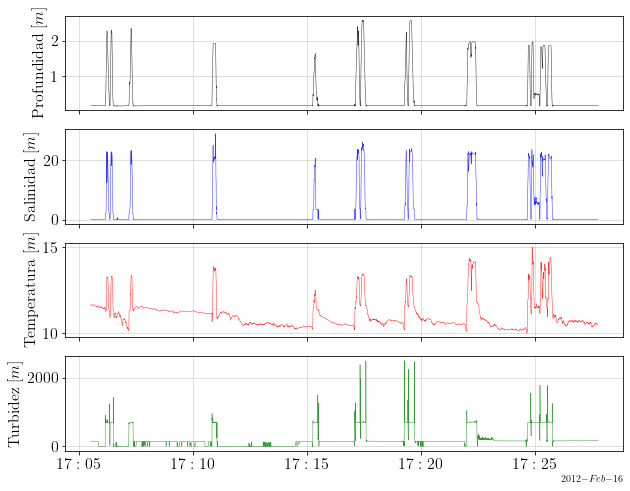

In [22]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,5,30):dtz.datetime(2012,2,16,17,27,45)]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 8), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(data_cut.index, data_cut['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax2.plot(data_cut.index, data_cut['Salinity'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax3.set_ylabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax3.plot(data_cut.index, data_cut['Temperature'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=16)

ax4.plot(data_cut.index, data_cut['Turbidity'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

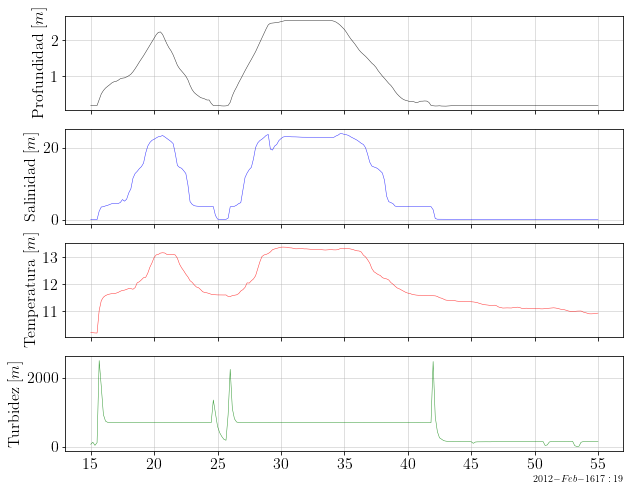

In [23]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,19,15):dtz.datetime(2012,2,16,17,19,55)]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 8), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(data_cut.index, data_cut['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=16)

ax2.plot(data_cut.index, data_cut['Salinity'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax3.set_ylabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax3.plot(data_cut.index, data_cut['Temperature'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=16)

ax4.plot(data_cut.index, data_cut['Turbidity'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

# Figuras moorings

In [18]:
dc1 = DC_1.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]
dc2 = DC_2.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]
dc3 = DC_3.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]
dc4 = DC_4.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]

nm1 = NM_1.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]
nm2 = NM_2.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]
nm3 = NM_3.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]

ml1 = ML_1.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]
ml2 = ML_2.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]

pc1 = PC_1.loc[dtz.datetime(2012,2,16,17,0,0):dtz.datetime(2012,2,16,17,30,0)]

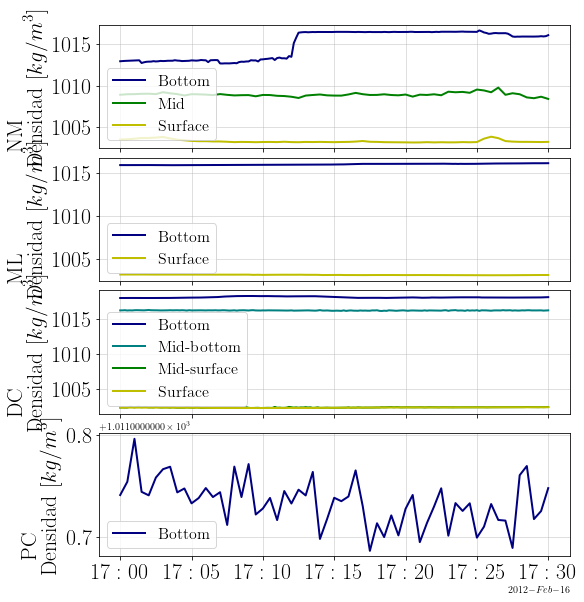

In [21]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(8, 8), constrained_layout=True, sharex=True)

ax1.set_ylabel(r"NM \\ Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.plot(nm1.index, nm1["Density"], color="navy", lw=2, label="Bottom")
ax1.plot(nm2.index, nm2["Density"], color="g", lw=2, label="Mid")
ax1.plot(nm3.index, nm3["Density"], color="y", lw=2, label="Surface")


ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"ML \\ Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax2.plot(ml1.index, ml1["Density"], color="navy", lw=2, label="Bottom")
ax2.plot(ml2.index, ml2["Density"], color="y", lw=2, label="Surface")

ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"DC \\ Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax3.plot(dc1.index, dc1["Density"], color="navy", lw=2, label="Bottom")
ax3.plot(dc2.index, dc2["Density"], color="teal", lw=2, label="Mid-bottom")
ax3.plot(dc3.index, dc3["Density"], color="g", lw=2, label="Mid-surface")
ax3.plot(dc4.index, dc4["Density"], color="y", lw=2, label="Surface")

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC \\ Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax4.plot(pc1.index, pc1["Density"], color="navy", lw=2, label="Bottom")

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

# Ajustar formato fecha

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

# Mapa

https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db

In [19]:
pes_m = plt.imread('data/map.png')
BBox = ((-122.41285,   -122.40585,      
         37.26246, 37.26748))

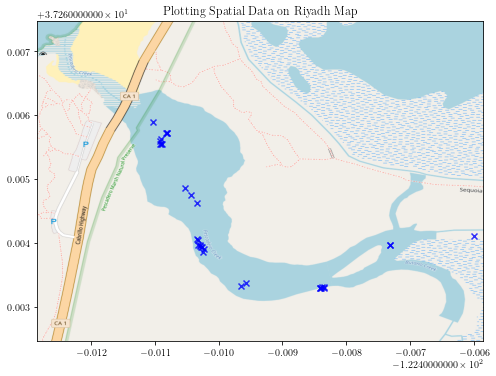

In [23]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.Longitud, df.Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')

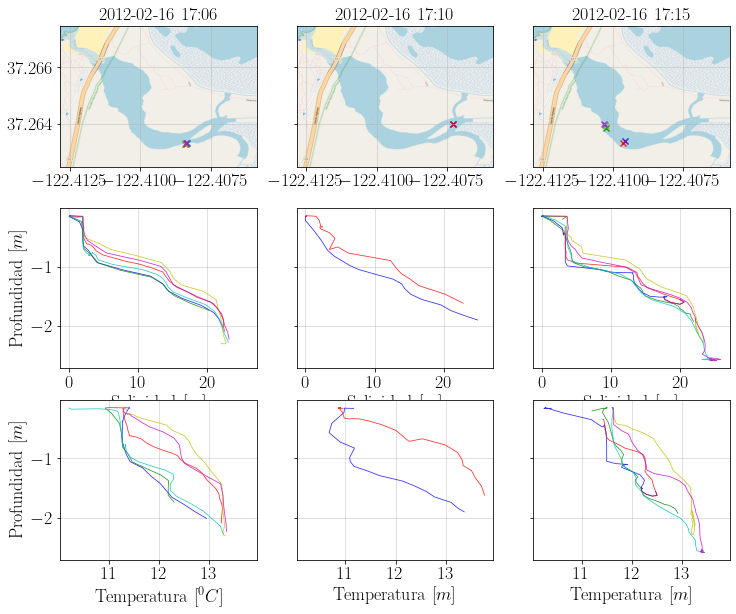

In [20]:
p1 = data.loc[dtz.datetime(2012,2,16,17,6,8):dtz.datetime(2012,2,16,17,6,12)]
p2 = data.loc[dtz.datetime(2012,2,16,17,6,14):dtz.datetime(2012,2,16,17,6,20)]
p3 = data.loc[dtz.datetime(2012,2,16,17,6,20):dtz.datetime(2012,2,16,17,6,23)]
p4 = data.loc[dtz.datetime(2012,2,16,17,6,25):dtz.datetime(2012,2,16,17,6,30)]
p5 = data.loc[dtz.datetime(2012,2,16,17,7,10):dtz.datetime(2012,2,16,17,7,16)]
p6 = data.loc[dtz.datetime(2012,2,16,17,7,17):dtz.datetime(2012,2,16,17,7,23)]

p7 = data.loc[dtz.datetime(2012,2,16,17,10,47):dtz.datetime(2012,2,16,17,10,52)]
p8 = data.loc[dtz.datetime(2012,2,16,17,10,59):dtz.datetime(2012,2,16,17,11,5)]

p9 = data.loc[dtz.datetime(2012,2,16,17,15,10):dtz.datetime(2012,2,16,17,15,21)]
p10 = data.loc[dtz.datetime(2012,2,16,17,15,20):dtz.datetime(2012,2,16,17,15,25)]
p11 = data.loc[dtz.datetime(2012,2,16,17,17,5):dtz.datetime(2012,2,16,17,17,11)]
p12 = data.loc[dtz.datetime(2012,2,16,17,17,13):dtz.datetime(2012,2,16,17,17,19)]
p13 = data.loc[dtz.datetime(2012,2,16,17,17,19):dtz.datetime(2012,2,16,17,17,25)]
p14 = data.loc[dtz.datetime(2012,2,16,17,17,25):dtz.datetime(2012,2,16,17,17,35)]
p15 = data.loc[dtz.datetime(2012,2,16,17,19,15):dtz.datetime(2012,2,16,17,19,20)]
p16 = data.loc[dtz.datetime(2012,2,16,17,19,20):dtz.datetime(2012,2,16,17,19,25)]
p17 = data.loc[dtz.datetime(2012,2,16,17,19,25):dtz.datetime(2012,2,16,17,19,29)]
p18 = data.loc[dtz.datetime(2012,2,16,17,19,31):dtz.datetime(2012,2,16,17,19,45)]




ig, ([[ax1, ax3, ax5], [ax2, ax4, ax6], [ax7, ax8, ax9]]) = plt.subplots(nrows=3, ncols=3, figsize = (12,10), sharey='row', sharex='row')
ax1.scatter(df.iloc[0].Longitud, df.iloc[0].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax1.scatter(df.iloc[1].Longitud, df.iloc[1].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax1.scatter(df.iloc[2].Longitud, df.iloc[2].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
ax1.scatter(df.iloc[3].Longitud, df.iloc[3].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')
ax1.scatter(df.iloc[4].Longitud, df.iloc[4].Latitud, zorder=1, alpha= 0.8, c='c', marker='x')
ax1.scatter(df.iloc[5].Longitud, df.iloc[5].Latitud, zorder=1, alpha= 0.8, c='m', marker='x')

ax1.set_title('2012-02-16 17:06',
          fontsize=18)
ax1.set_xlim(BBox[0],BBox[1])
ax1.set_ylim(BBox[2],BBox[3])
ax1.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')
ax1.get_xaxis().get_major_formatter().set_useOffset(False)
ax1.get_yaxis().get_major_formatter().set_useOffset(False)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=18)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=18)

ax2.plot(p1['Salinity'].values, -p1['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax2.plot(p2['Salinity'].values, -p2['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax2.plot(p3['Salinity'].values, -p3['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax2.plot(p4['Salinity'].values, -p4['Depth'].values, c='y', alpha=0.8, linewidth=0.8)
ax2.plot(p5['Salinity'].values, -p5['Depth'].values, c='c', alpha=0.8, linewidth=0.8)
ax2.plot(p6['Salinity'].values, -p6['Depth'].values, c='m', alpha=0.8, linewidth=0.8)


ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.grid(alpha=0.5)

ax7.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=18)
ax7.set_xlabel(r"Temperatura "
          r"$\displaystyle[^0C]$",
          fontsize=18)

ax7.plot(p1['Temperature'].values, -p1['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax7.plot(p2['Temperature'].values, -p2['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax7.plot(p3['Temperature'].values, -p3['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax7.plot(p4['Temperature'].values, -p4['Depth'].values, c='y', alpha=0.8, linewidth=0.8)
ax7.plot(p5['Temperature'].values, -p5['Depth'].values, c='c', alpha=0.8, linewidth=0.8)
ax7.plot(p6['Temperature'].values, -p6['Depth'].values, c='m', alpha=0.8, linewidth=0.8)


ax7.xaxis.set_tick_params(labelsize=18)
ax7.yaxis.set_tick_params(labelsize=18)
ax7.grid(alpha=0.5)

ax3.scatter(df.iloc[6].Longitud, df.iloc[6].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax3.scatter(df.iloc[7].Longitud, df.iloc[7].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')

ax3.set_title('2012-02-16 17:10',
          fontsize=18)
ax3.set_xlim(BBox[0],BBox[1])
ax3.set_ylim(BBox[2],BBox[3])
ax3.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')
ax3.get_xaxis().get_major_formatter().set_useOffset(False)
ax3.get_yaxis().get_major_formatter().set_useOffset(False)

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax3.grid(alpha=0.5)


ax4.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=18)

ax4.plot(p7['Salinity'].values, -p7['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax4.plot(p8['Salinity'].values, -p8['Depth'].values, c='r', alpha=0.8, linewidth=0.8)


ax4.xaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)
ax4.grid(alpha=0.5)

ax8.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=18)

ax8.plot(p7['Temperature'].values, -p7['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax8.plot(p8['Temperature'].values, -p8['Depth'].values, c='r', alpha=0.8, linewidth=0.8)


ax8.xaxis.set_tick_params(labelsize=18)
ax8.yaxis.set_tick_params(labelsize=18)
ax8.grid(alpha=0.5)

ax5.scatter(df.iloc[8].Longitud, df.iloc[8].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax5.scatter(df.iloc[9].Longitud, df.iloc[9].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax5.scatter(df.iloc[10].Longitud, df.iloc[10].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
ax5.scatter(df.iloc[11].Longitud, df.iloc[11].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')
ax5.scatter(df.iloc[12].Longitud, df.iloc[12].Latitud, zorder=1, alpha= 0.8, c='c', marker='x')
ax5.scatter(df.iloc[13].Longitud, df.iloc[13].Latitud, zorder=1, alpha= 0.8, c='m', marker='x')

ax5.set_title('2012-02-16 17:15',
          fontsize=18)
ax5.set_xlim(BBox[0],BBox[1])
ax5.set_ylim(BBox[2],BBox[3])
ax5.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')
ax5.get_xaxis().get_major_formatter().set_useOffset(False)
ax5.get_yaxis().get_major_formatter().set_useOffset(False)

ax5.xaxis.set_tick_params(labelsize=18)
ax5.yaxis.set_tick_params(labelsize=18)
ax5.grid(alpha=0.5)


ax6.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=18)

ax6.plot(p9['Salinity'].values, -p9['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax6.plot(p10['Salinity'].values, -p10['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax6.plot(p11['Salinity'].values, -p11['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax6.plot(p12['Salinity'].values, -p12['Depth'].values, c='y', alpha=0.8, linewidth=0.8)
ax6.plot(p13['Salinity'].values, -p13['Depth'].values, c='c', alpha=0.8, linewidth=0.8)
ax6.plot(p14['Salinity'].values, -p14['Depth'].values, c='m', alpha=0.8, linewidth=0.8)

ax6.xaxis.set_tick_params(labelsize=18)
ax6.yaxis.set_tick_params(labelsize=18)
ax6.grid(alpha=0.5)

ax9.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=18)

ax9.plot(p9['Temperature'].values, -p9['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax9.plot(p10['Temperature'].values, -p10['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax9.plot(p11['Temperature'].values, -p11['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax9.plot(p12['Temperature'].values, -p12['Depth'].values, c='y', alpha=0.8, linewidth=0.8)
ax9.plot(p13['Temperature'].values, -p13['Depth'].values, c='c', alpha=0.8, linewidth=0.8)
ax9.plot(p14['Temperature'].values, -p14['Depth'].values, c='m', alpha=0.8, linewidth=0.8)

ax9.xaxis.set_tick_params(labelsize=18)
ax9.yaxis.set_tick_params(labelsize=18)
ax9.grid(alpha=0.5)

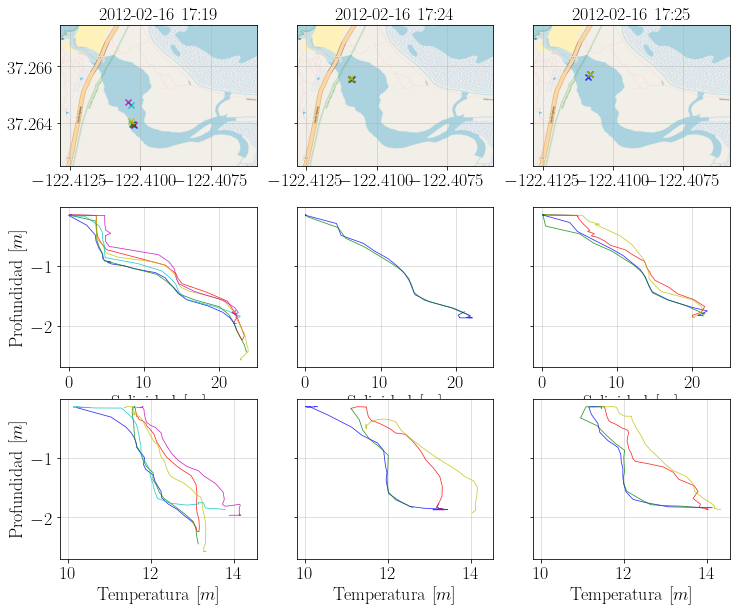

In [21]:
p15 = data.loc[dtz.datetime(2012,2,16,17,19,15):dtz.datetime(2012,2,16,17,19,20)]
p16 = data.loc[dtz.datetime(2012,2,16,17,19,20):dtz.datetime(2012,2,16,17,19,25)]
p17 = data.loc[dtz.datetime(2012,2,16,17,19,25):dtz.datetime(2012,2,16,17,19,29)]
p18 = data.loc[dtz.datetime(2012,2,16,17,19,31):dtz.datetime(2012,2,16,17,19,45)]
p19 = data.loc[dtz.datetime(2012,2,16,17,21,55):dtz.datetime(2012,2,16,17,22,4)]
p20 = data.loc[dtz.datetime(2012,2,16,17,22,15):dtz.datetime(2012,2,16,17,22,30)]

p21 = data.loc[dtz.datetime(2012,2,16,17,24,35):dtz.datetime(2012,2,16,17,24,45)]
p22 = data.loc[dtz.datetime(2012,2,16,17,24,44):dtz.datetime(2012,2,16,17,24,49)]
p23 = data.loc[dtz.datetime(2012,2,16,17,24,49):dtz.datetime(2012,2,16,17,24,51)]
p24 = data.loc[dtz.datetime(2012,2,16,17,24,54):dtz.datetime(2012,2,16,17,25,0)]

p25 = data.loc[dtz.datetime(2012,2,16,17,25,11):dtz.datetime(2012,2,16,17,25,15)]
p26 = data.loc[dtz.datetime(2012,2,16,17,25,25):dtz.datetime(2012,2,16,17,25,30)]
p27 = data.loc[dtz.datetime(2012,2,16,17,25,30):dtz.datetime(2012,2,16,17,25,35)]
p28 = data.loc[dtz.datetime(2012,2,16,17,25,40):dtz.datetime(2012,2,16,17,25,45)]



ig, ([[ax1, ax3, ax5], [ax2, ax4, ax6], [ax7, ax8, ax9]]) = plt.subplots(nrows=3, ncols=3, figsize = (12,10), sharey='row', sharex='row')

ax1.scatter(df.iloc[14].Longitud, df.iloc[14].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax1.scatter(df.iloc[15].Longitud, df.iloc[15].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax1.scatter(df.iloc[16].Longitud, df.iloc[16].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
ax1.scatter(df.iloc[17].Longitud, df.iloc[17].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')
ax1.scatter(df.iloc[18].Longitud, df.iloc[18].Latitud, zorder=1, alpha= 0.8, c='c', marker='x')
ax1.scatter(df.iloc[19].Longitud, df.iloc[19].Latitud, zorder=1, alpha= 0.8, c='m', marker='x')

ax1.set_title('2012-02-16 17:19',
          fontsize=18)
ax1.set_xlim(BBox[0],BBox[1])
ax1.set_ylim(BBox[2],BBox[3])
ax1.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')
ax1.get_xaxis().get_major_formatter().set_useOffset(False)
ax1.get_yaxis().get_major_formatter().set_useOffset(False)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=18)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=18)

ax2.plot(p15['Salinity'].values, -p15['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax2.plot(p16['Salinity'].values, -p16['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax2.plot(p17['Salinity'].values, -p17['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax2.plot(p18['Salinity'].values, -p18['Depth'].values, c='y', alpha=0.8, linewidth=0.8)
ax2.plot(p19['Salinity'].values, -p19['Depth'].values, c='c', alpha=0.8, linewidth=0.8)
ax2.plot(p20['Salinity'].values, -p20['Depth'].values, c='m', alpha=0.8, linewidth=0.8)

ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.grid(alpha=0.5)

ax7.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=18)
ax7.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=18)

ax7.plot(p15['Temperature'].values, -p15['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax7.plot(p16['Temperature'].values, -p16['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax7.plot(p17['Temperature'].values, -p17['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax7.plot(p18['Temperature'].values, -p18['Depth'].values, c='y', alpha=0.8, linewidth=0.8)
ax7.plot(p19['Temperature'].values, -p19['Depth'].values, c='c', alpha=0.8, linewidth=0.8)
ax7.plot(p20['Temperature'].values, -p20['Depth'].values, c='m', alpha=0.8, linewidth=0.8)

ax7.xaxis.set_tick_params(labelsize=18)
ax7.yaxis.set_tick_params(labelsize=18)
ax7.grid(alpha=0.5)

ax3.scatter(df.iloc[20].Longitud, df.iloc[20].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax3.scatter(df.iloc[21].Longitud, df.iloc[21].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax3.scatter(df.iloc[22].Longitud, df.iloc[22].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
ax3.scatter(df.iloc[23].Longitud, df.iloc[23].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')

ax3.set_title('2012-02-16 17:24',
          fontsize=18)
ax3.set_xlim(BBox[0],BBox[1])
ax3.set_ylim(BBox[2],BBox[3])
ax3.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')
ax3.get_xaxis().get_major_formatter().set_useOffset(False)
ax3.get_yaxis().get_major_formatter().set_useOffset(False)

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax3.grid(alpha=0.5)


ax4.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=18)

ax4.plot(p21['Salinity'].values, -p21['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
# ax4.plot(p22['Salinity'].values, -p22['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax4.plot(p23['Salinity'].values, -p23['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
# ax4.plot(p24['Salinity'].values, -p24['Depth'].values, c='y', alpha=0.8, linewidth=0.8)


ax4.xaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)
ax4.grid(alpha=0.5)

ax8.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=18)

ax8.plot(p21['Temperature'].values, -p21['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax8.plot(p22['Temperature'].values, -p22['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax8.plot(p23['Temperature'].values, -p23['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax8.plot(p24['Temperature'].values, -p24['Depth'].values, c='y', alpha=0.8, linewidth=0.8)


ax8.xaxis.set_tick_params(labelsize=18)
ax8.yaxis.set_tick_params(labelsize=18)
ax8.grid(alpha=0.5)


ax5.scatter(df.iloc[24].Longitud, df.iloc[24].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
ax5.scatter(df.iloc[25].Longitud, df.iloc[25].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax5.scatter(df.iloc[26].Longitud, df.iloc[26].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
ax5.scatter(df.iloc[27].Longitud, df.iloc[27].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')

ax5.set_title('2012-02-16 17:25',
          fontsize=18)
ax5.set_xlim(BBox[0],BBox[1])
ax5.set_ylim(BBox[2],BBox[3])
ax5.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')
ax5.get_xaxis().get_major_formatter().set_useOffset(False)
ax5.get_yaxis().get_major_formatter().set_useOffset(False)

ax5.xaxis.set_tick_params(labelsize=18)
ax5.yaxis.set_tick_params(labelsize=18)
ax5.grid(alpha=0.5)


ax6.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=18)

ax6.plot(p25['Salinity'].values, -p25['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax6.plot(p26['Salinity'].values, -p26['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax6.plot(p27['Salinity'].values, -p27['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax6.plot(p28['Salinity'].values, -p28['Depth'].values, c='y', alpha=0.8, linewidth=0.8)

ax6.xaxis.set_tick_params(labelsize=18)
ax6.yaxis.set_tick_params(labelsize=18)
ax6.grid(alpha=0.5)

ax9.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=18)

ax9.plot(p25['Temperature'].values, -p25['Depth'].values, c='b', alpha=0.8, linewidth=0.8)
ax9.plot(p26['Temperature'].values, -p26['Depth'].values, c='r', alpha=0.8, linewidth=0.8)
ax9.plot(p27['Temperature'].values, -p27['Depth'].values, c='g', alpha=0.8, linewidth=0.8)
ax9.plot(p28['Temperature'].values, -p28['Depth'].values, c='y', alpha=0.8, linewidth=0.8)

ax9.xaxis.set_tick_params(labelsize=18)
ax9.yaxis.set_tick_params(labelsize=18)
ax9.grid(alpha=0.5)

In [22]:
# rho_nm = np.array([nm3["Density"].loc[dtz.datetime(2012,2,16,17,20,0)], nm2["Density"].loc[dtz.datetime(2012,2,16,17,20,0)], nm1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]])
# rho_dc = np.array([dc4["Density"].loc[dtz.datetime(2012,2,16,17,20,0)], dc3["Density"].loc[dtz.datetime(2012,2,16,17,20,0)], dc2["Density"].loc[dtz.datetime(2012,2,16,17,20,0)], dc1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]])
# rho_ml = np.array([ml2["Density"].loc[dtz.datetime(2012,2,16,17,20,0)], ml1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]])
# rho_pc = np.array([pc1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]])

# z_nm = np.array([nm3["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], nm2["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], nm1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)]])
# z_dc = np.array([dc4["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc3["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc2["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)]])
# z_ml = np.array([ml2["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], ml1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)]])
# z_pc = np.array([pc1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)]])

rhoz_nm = np.array([[nm3["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], nm3["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]],
                        [nm2["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], nm2["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]],
                        [nm1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], nm1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]]])

rhoz_ml = np.array([[ml2["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], ml2["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]],
                        [ml1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], ml1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]]])

rhoz_dc = np.array([[dc4["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc4["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]],
                        [dc3["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc3["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]],
                        [dc2["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc2["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]],
                        [dc1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], dc1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]]])

rhoz_pc = np.array([[p7['Depth'].iloc[0], p7['Density'].iloc[0]],
                        [pc1["Depth"].loc[dtz.datetime(2012,2,16,17,20,0)], pc1["Density"].loc[dtz.datetime(2012,2,16,17,20,0)]]])


p_nm = pd.DataFrame(rhoz_nm, columns=['Depth', 'Density'])
p_dc = pd.DataFrame(rhoz_dc, columns=['Depth', 'Density'])
p_ml = pd.DataFrame(rhoz_ml, columns=['Depth', 'Density'])
p_pc = pd.DataFrame(rhoz_pc, columns=['Depth', 'Density'])

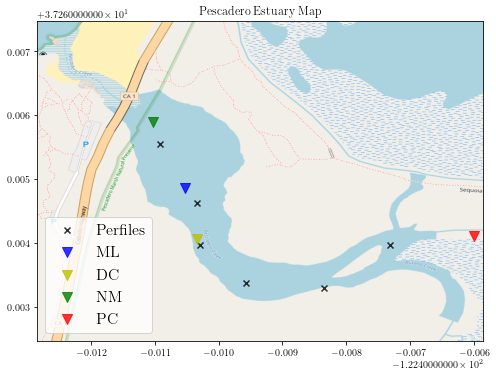

In [60]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.iloc[0].Longitud, df.iloc[0].Latitud, zorder=1, alpha= 0.8, c='k', marker='x')
# ax.scatter(df.iloc[1].Longitud, df.iloc[1].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
# ax.scatter(df.iloc[2].Longitud, df.iloc[2].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
# ax.scatter(df.iloc[3].Longitud, df.iloc[3].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')
# ax.scatter(df.iloc[4].Longitud, df.iloc[4].Latitud, zorder=1, alpha= 0.8, c='c', marker='x')
# ax.scatter(df.iloc[5].Longitud, df.iloc[5].Latitud, zorder=1, alpha= 0.8, c='m', marker='x')
ax3=ax

ax3.scatter(df.iloc[6].Longitud, df.iloc[6].Latitud, zorder=1, alpha= 0.8, c='k', marker='x')
# ax3.scatter(df.iloc[7].Longitud, df.iloc[7].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax5=ax

ax5.scatter(df.iloc[8].Longitud, df.iloc[8].Latitud, zorder=1, alpha= 0.8, c='k', marker='x')
# ax5.scatter(df.iloc[9].Longitud, df.iloc[9].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
# ax5.scatter(df.iloc[10].Longitud, df.iloc[10].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
# ax5.scatter(df.iloc[11].Longitud, df.iloc[11].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')
# ax5.scatter(df.iloc[12].Longitud, df.iloc[12].Latitud, zorder=1, alpha= 0.8, c='c', marker='x')
# ax5.scatter(df.iloc[13].Longitud, df.iloc[13].Latitud, zorder=1, alpha= 0.8, c='m', marker='x')

ax1 = ax
# ax1.scatter(df.iloc[14].Longitud, df.iloc[14].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
# ax1.scatter(df.iloc[15].Longitud, df.iloc[15].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax1.scatter(df.iloc[16].Longitud, df.iloc[16].Latitud, zorder=1, alpha= 0.8, c='k', marker='x')
# ax1.scatter(df.iloc[17].Longitud, df.iloc[17].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')
ax1.scatter(df.iloc[18].Longitud, df.iloc[18].Latitud, zorder=1, alpha= 0.8, c='k', marker='x')
# ax1.scatter(df.iloc[19].Longitud, df.iloc[19].Latitud, zorder=1, alpha= 0.8, c='m', marker='x')

# ax3.scatter(df.iloc[20].Longitud, df.iloc[20].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
# ax3.scatter(df.iloc[21].Longitud, df.iloc[21].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
ax3.scatter(df.iloc[22].Longitud, df.iloc[22].Latitud, zorder=1, alpha= 0.8, c='k', marker='x', label="Perfiles")
# ax3.scatter(df.iloc[23].Longitud, df.iloc[23].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')

# ax5.scatter(df.iloc[24].Longitud, df.iloc[24].Latitud, zorder=1, alpha= 0.8, c='b', marker='x')
# ax5.scatter(df.iloc[25].Longitud, df.iloc[25].Latitud, zorder=1, alpha= 0.8, c='r', marker='x')
# ax5.scatter(df.iloc[26].Longitud, df.iloc[26].Latitud, zorder=1, alpha= 0.8, c='g', marker='x')
# ax5.scatter(df.iloc[27].Longitud, df.iloc[27].Latitud, zorder=1, alpha= 0.8, c='y', marker='x')

# Moorings
# ax5.scatter(-122.410527778, 37.264861111, s=100,  alpha= 0.8, c='b', marker='v', label="ML") #ML
# ax5.scatter(-122.410333333, 37.264055556, s=100, alpha= 0.8, c='y', marker='v', label="DC") #DC
# ax5.scatter(-122.411027778, 37.265888889, s=100, alpha= 0.8, c='g', marker='v', label="NM") #NM
# ax5.scatter(-122.406000000, 37.264111111, s=100, alpha= 0.8, c='r', marker='v', label="PC") #PC

ax3.scatter(df.iloc[-4].Longitud, df.iloc[-4].Latitud, s=100, alpha= 0.8, c='b', marker='v', label="ML")
ax3.scatter(df.iloc[-3].Longitud, df.iloc[-3].Latitud, s=100, alpha= 0.8, c='y', marker='v', label="DC")
ax3.scatter(df.iloc[-2].Longitud, df.iloc[-2].Latitud, s=100, alpha= 0.8, c='g', marker='v', label="NM")
ax3.scatter(df.iloc[-1].Longitud, df.iloc[-1].Latitud, s=100, alpha= 0.8, c='r', marker='v', label="PC")

ax.legend(loc='lower left',
          fontsize=16)
ax.set_title('Pescadero Estuary Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(pes_m, zorder=0, extent = BBox, aspect= 'equal')

## Color map

In [23]:
# coord = df.iloc[[-2, 22, -4, 18, -3, 16, 8, 0, 6, -1]] # indices son 1 numero mas peque;os que el de los p
# prof = np.array([p_nm, p23, p_ml, p19, p_dc, p17, p9, p1, p7, p_pc], dtype=object)

coord = df.iloc[[ 22, 18, 16, 8, 0, 6, -1]] # indices son 1 numero mas peque;os que el de los p
prof = np.array([ p23, p19, p17, p9, p1, p7, p_pc], dtype=object)

x = np.zeros((len(coord)))
for i in range(len(x)-1):
    lat1 = coord.iloc[i]['Latitud']
    lon1 = coord.iloc[i]['Longitud']
    lat2 = coord.iloc[i+1]['Latitud']
    lon2 = coord.iloc[i+1]['Longitud']
    dist = haversine(lat1, lon1, lat2, lon2)*1000
    x[i+1] = dist + x[i]


#Moorings
coord_m = df.iloc[[-2, -4, -3]] # indices son 1 numero mas peque;os que el de los p
prof_m = np.array([p_nm, p_ml, p_dc, p17], dtype=object)


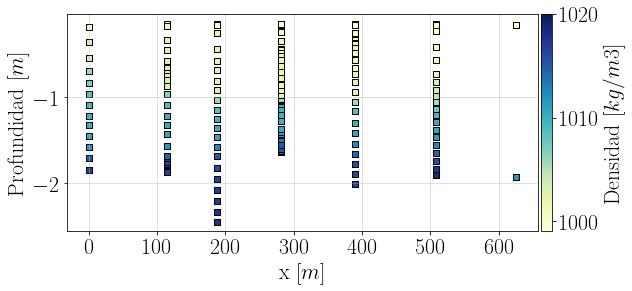

In [37]:
fig, (ax3) = plt.subplots(nrows=1, figsize=(10, 4))


#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.set_xlabel(r"x "
          r"$\displaystyle[m]$",
          fontsize=22)

for i in range(len(x)):
    scat = ax3.scatter([x[i]] * len(prof[i]), -prof[i]['Depth'], c=prof[i]['Density'], marker='s', cmap=cm.YlGnBu, vmin=999, vmax=1020, edgecolors='k')

cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
cbar2.set_label("Densidad [$kg/m3$]", loc='center',
          fontsize=22)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

## Interpolacion

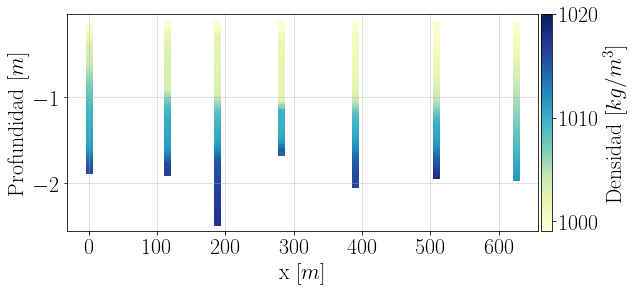

In [25]:
fig, (ax3) = plt.subplots(nrows=1, figsize=(10, 4))


#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.set_xlabel(r"x "
          r"$\displaystyle[m]$",
          fontsize=22)
s_list = []
z_list = []
for i in range(len(x)):
    s = prof[i]['Density']
    z = -prof[i]['Depth']
    f = interp1d(z, s)
    znew = np.linspace(-max(prof[i]['Depth']), -min(prof[i]['Depth']), num=100, endpoint=True)
    z_list.append(znew)
    s_list.append(f(znew))
    scat = ax3.scatter([x[i]] * len(znew), znew, c=f(znew), marker='s', cmap=cm.YlGnBu, vmin=999, vmax=1020)

cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

In [26]:
# Z = np.concatenate((z_list[0].reshape(1, -1), z_list[1].reshape(1, -1), z_list[2].reshape(1, -1), z_list[3].reshape(1, -1), z_list[4].reshape(1, -1), z_list[5].reshape(1, -1), z_list[6].reshape(1, -1), z_list[7].reshape(1, -1), z_list[8].reshape(1, -1), z_list[9].reshape(1, -1)), axis=1)
# S = np.concatenate((s_list[0].reshape(1, -1), s_list[1].reshape(1, -1), s_list[2].reshape(1, -1), s_list[3].reshape(1, -1), s_list[4].reshape(1, -1), s_list[5].reshape(1, -1), s_list[6].reshape(1, -1), s_list[7].reshape(1, -1), s_list[8].reshape(1, -1), s_list[9].reshape(1, -1)), axis=1)

Z = np.concatenate((z_list[0].reshape(1, -1), z_list[1].reshape(1, -1), z_list[2].reshape(1, -1), z_list[3].reshape(1, -1), z_list[4].reshape(1, -1), z_list[5].reshape(1, -1), z_list[6].reshape(1, -1)), axis=1)
S = np.concatenate((s_list[0].reshape(1, -1), s_list[1].reshape(1, -1), s_list[2].reshape(1, -1), s_list[3].reshape(1, -1), s_list[4].reshape(1, -1), s_list[5].reshape(1, -1), s_list[6].reshape(1, -1)), axis=1)

# S_pre = np.array([s_list[0], s_list[1], s_list[2], s_list[3], s_list[4], s_list[5]])


X = np.zeros((1, 700))
for i in range(len(x)):
    for j in range(len(z_list[i])):
        X[0,j+100*i] = x[i]

# S = np.empty((6, 600))
# S[:] = np.NaN

# S = np.zeros((6,600))

# for i in range(len(x)):
#     for j in range(len(z_list[i])):
#         S[i,j+100*i] = S_pre[i,j]

grid_z, grid_x = np.mgrid[-2.5:0:250j, 0:665:665j]

points = np.concatenate((X, Z), axis=0)
grid_z1 = griddata(np.transpose(points), S[0,:], (grid_x, grid_z), method='linear')


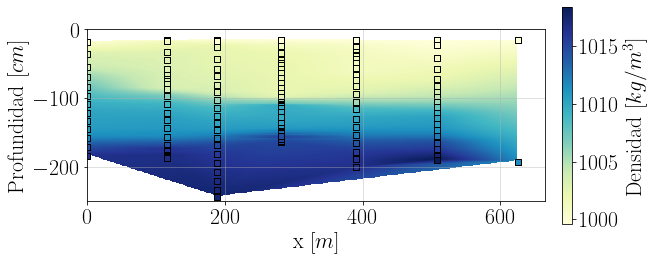

In [46]:
#Ajustar limites colorbar
umin = S.min()
umax = S.max()
level_boundaries_u = np.linspace(umin, umax, 400)

fig, (ax1) = plt.subplots(nrows=1, figsize=(10, 4))

for i in range(len(x)):
    scat = ax1.scatter([x[i]] * len(prof[i]), -prof[i]['Depth']*100, c=prof[i]['Density'], marker='s', cmap=cm.YlGnBu, vmin=umin, vmax=umax, edgecolors='k')


img_ = ax1.imshow(np.transpose(grid_z1).T, origin='lower', cmap=cm.YlGnBu,
                         vmax=umax, vmin=umin,
                 extent =[grid_x.min(), grid_x.max(), grid_z.min()*100, grid_z.max()*100]) 

cbar = fig.colorbar(img_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=22)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[cm]$",
          fontsize=22)
ax1.set_xlabel(r"x "
          r"$\displaystyle[m]$",
          fontsize=22)


cbar.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)




ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)

In [28]:
# #Ajustar limites colorbar
# umin = 0
# umax = 20
# level_boundaries_u = np.linspace(umin, umax, 400)

# #Inicio figura
# fig, (ax3) = plt.subplots(figsize=(8, 4))


# #Grafico de velocidad del agua (color map)

# contourf_ = ax3.contourf(x, Z[0,:],
#                          np.transpose(S),
#                          levels=level_boundaries_u,
#                          cmap=cm.YlGnBu,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
# cbar.ax.tick_params(labelsize=16)
# # cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# ax3.set_ylabel(r"Depth "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax3.grid(alpha=0.5)
# ax3.xaxis.set_tick_params(labelsize=16)
# ax3.yaxis.set_tick_params(labelsize=16)



In [29]:
# def func(x, y):
#     return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

# grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

# rng = np.random.default_rng()
# points = rng.random((1000, 2))
# values = func(points[:,0], points[:,1])

# # grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

# points.shape

In [30]:
# x = prof[0]['Salinity']
# y = -prof[0]['Depth']
# f = interp1d(y, x)
# # f2 = interp1d(x, y, kind='cubic')

# xnew = np.linspace(-max(prof[3]['Depth']), 0, num=100, endpoint=True)
# # import matplotlib.pyplot as plt
# # plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
# # plt.legend(['data', 'linear', 'cubic'], loc='best')
# # plt.show()

# fig, (ax2) = plt.subplots(figsize=(10, 6))

# fig.suptitle('2012-02-16 17:06:10 Lat:"37.263298" Lon:"-122.408351"', fontsize=22)
# #Formato fecha
# locator = mdates.AutoDateLocator()
# formatter = mdates.ConciseDateFormatter(locator)

# ax2.set_ylabel(r"Profundidad "
#           r"$\displaystyle[m]$",
#           fontsize=22)
# ax2.set_xlabel(r"Salinidad "
#           r"$\displaystyle[m]$",
#           fontsize=22)

# ax2.scatter(x, y, c='b', alpha=0.8, linewidth=0.5)
# ax2.plot(f(xnew), xnew, c='b', alpha=0.8, linewidth=0.5)

# ax2.xaxis.set_tick_params(labelsize=22)
# ax2.yaxis.set_tick_params(labelsize=22)
# ax2.grid(alpha=0.5)

## Potential anomaly 

In [40]:
#sin interpolar

# phi_p7 = phi_2(p7['Depth'].values, p7['Density'].values)
# phi_p1 = phi_2(p1['Depth'].values, p1['Density'].values)
# phi_p9 = phi_2(p9['Depth'].values, p9['Density'].values)
# phi_p17 = phi_2(p17['Depth'].values, p17['Density'].values)
# phi_p19 = phi_2(p19['Depth'].values, p19['Density'].values)
# phi_p23 = phi_2(p23['Depth'].values, p23['Density'].values)


# rho_pot = np.array([phi_p7, phi_p1, phi_p9, phi_p17, phi_p19, phi_p23], dtype=object)

In [27]:
# interpolando en z
d_list2 = []
z_list2 = []
for i in range(len(x)):
    d = prof[i]['Density']
    z2 = prof[i]['Depth']
    f2 = interp1d(z2, d)
    znew2 = np.linspace(min(prof[i]['Depth']), max(prof[i]['Depth']), num=100, endpoint=True)
    z_list2.append(znew2)
    d_list2.append(f2(znew2))



In [28]:
phi_pNM = phi_1(z_list2[0], d_list2[0])
phi_p23 = phi_1(z_list2[1], d_list2[1])
phi_pml = phi_1(z_list2[2], d_list2[2])
phi_p19 = phi_1(z_list2[3], d_list2[3])
phi_pdc = phi_1(z_list2[4], d_list2[4])
phi_p17 = phi_1(z_list2[5], d_list2[5])
phi_p9 = phi_1(z_list2[6], d_list2[6])
phi_p1 = phi_1(z_list2[7], d_list2[7])
phi_p7 = phi_1(z_list2[8], d_list2[8])
phi_ppc = phi_1(z_list2[9], d_list2[9])

rho_pot = np.array([phi_pNM, phi_p23, phi_pml, phi_p19, phi_pdc, phi_p17, phi_p9, phi_p1, phi_p7, phi_ppc], dtype=object)

IndexError: list index out of range

In [104]:
p7['Depth'].shape

(31,)

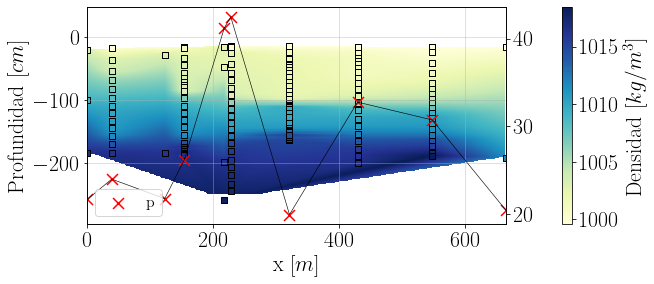

In [107]:
#Ajustar limites colorbar
umin = S.min()
umax = S.max()
level_boundaries_u = np.linspace(umin, umax, 400)

fig, (ax1) = plt.subplots(nrows=1, figsize=(10, 4))

for i in range(len(x)):
    scat = ax1.scatter([x[i]] * len(prof[i]), -prof[i]['Depth']*100, c=prof[i]['Density'], marker='s', cmap=cm.YlGnBu, vmin=umin, vmax=umax, edgecolors='k')


img_ = ax1.imshow(np.transpose(grid_z1).T, origin='lower', cmap=cm.YlGnBu,
                         vmax=umax, vmin=umin,
                 extent =[grid_x.min(), grid_x.max(), grid_z.min()*100, grid_z.max()*100]) 

cbar = fig.colorbar(img_, ax=ax1, pad=0.1)
cbar.ax.tick_params(labelsize=22)

ax1.set_ylabel(r"Profundidad "
          r"$\displaystyle[cm]$",
          fontsize=22)
ax1.set_xlabel(r"x "
          r"$\displaystyle[m]$",
          fontsize=22)


cbar.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)

ax7 = ax1.twinx()
ax7.scatter(x, rho_pot[:,1], marker="x", color="r", s=120)

ax7.yaxis.set_tick_params(labelsize=22)
ax7.legend("phi", loc='lower left',
          fontsize=16)
ax7.plot(x, rho_pot[:,1], color="k", lw=0.6)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)

## Perfiles

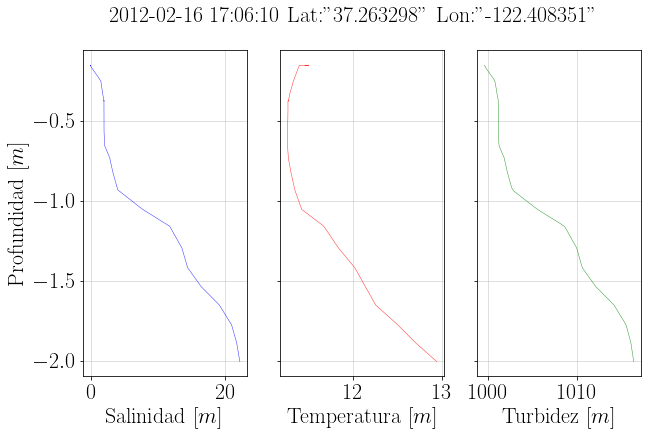

In [68]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,6,7):dtz.datetime(2012,2,16,17,6,12)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:06:10 Lat:"37.263298" Lon:"-122.408351"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.plot(p1['Salinity'].values, -p1['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.plot(p1['Temperature'].values, -p1['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.plot(s_list[1], z_list[1], c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

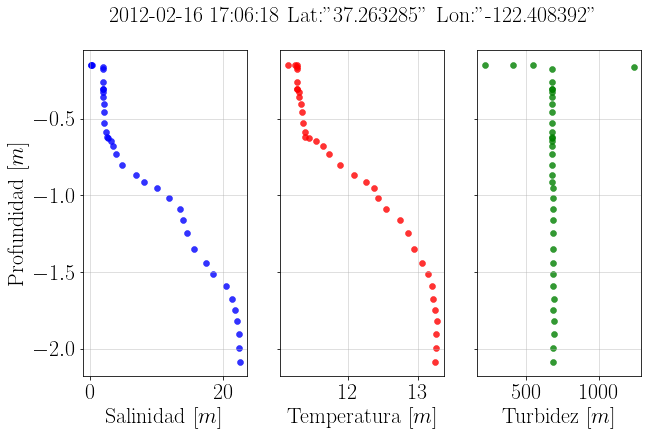

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,6,14):dtz.datetime(2012,2,16,17,6,20)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:06:18 Lat:"37.263285" Lon:"-122.408392"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

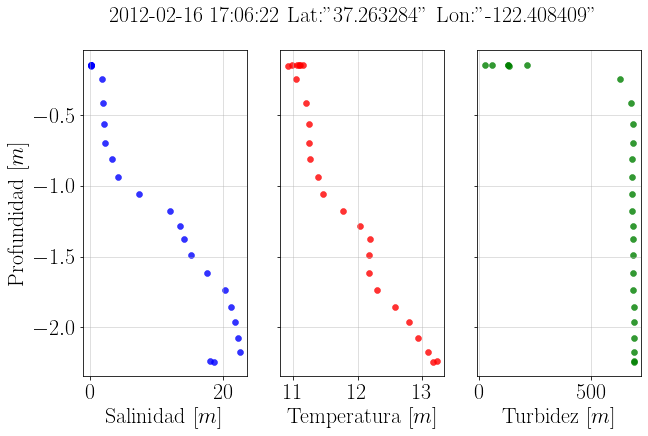

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,6,20):dtz.datetime(2012,2,16,17,6,24)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:06:22 Lat:"37.263284" Lon:"-122.408409"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

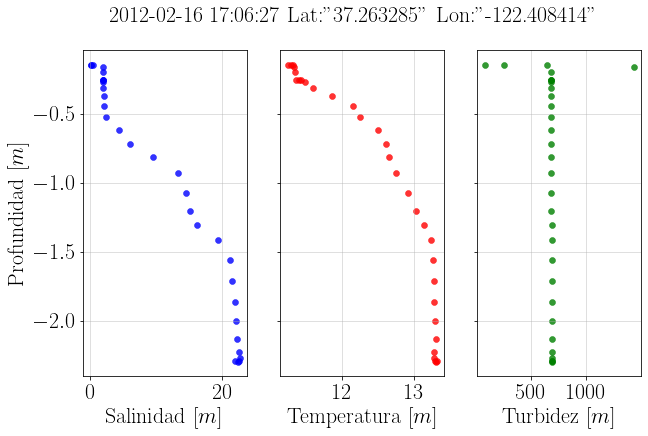

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,6,25):dtz.datetime(2012,2,16,17,6,30)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:06:27 Lat:"37.263285" Lon:"-122.408414"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

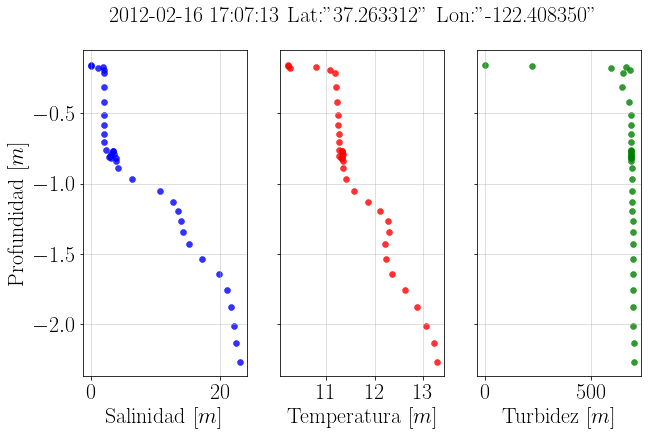

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,7,10):dtz.datetime(2012,2,16,17,7,16)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:07:13 Lat:"37.263312" Lon:"-122.408350"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

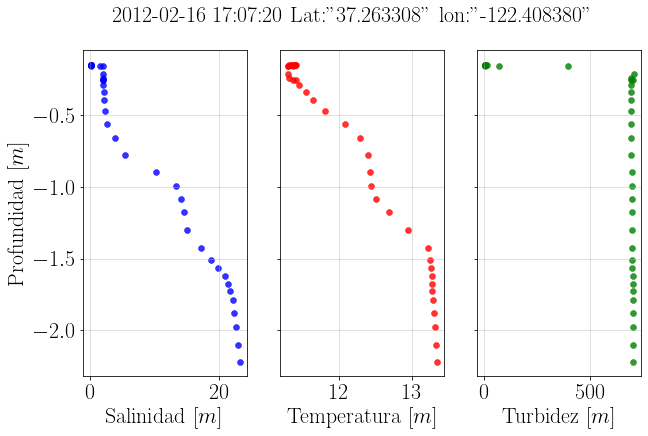

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,7,17):dtz.datetime(2012,2,16,17,7,23)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:07:20 Lat:"37.263308" lon:"-122.408380"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

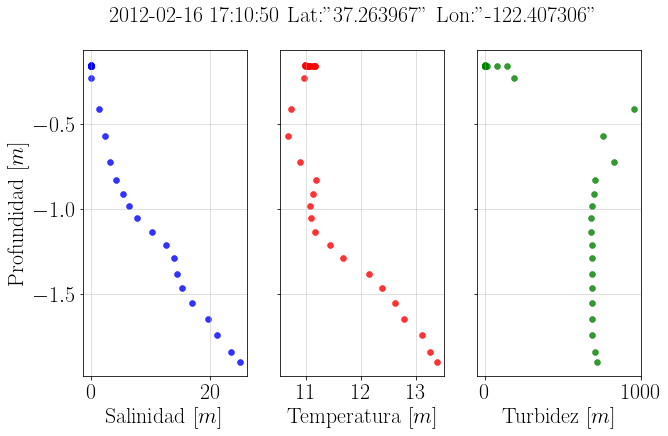

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,10,47):dtz.datetime(2012,2,16,17,10,52)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:10:50 Lat:"37.263967" Lon:"-122.407306"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

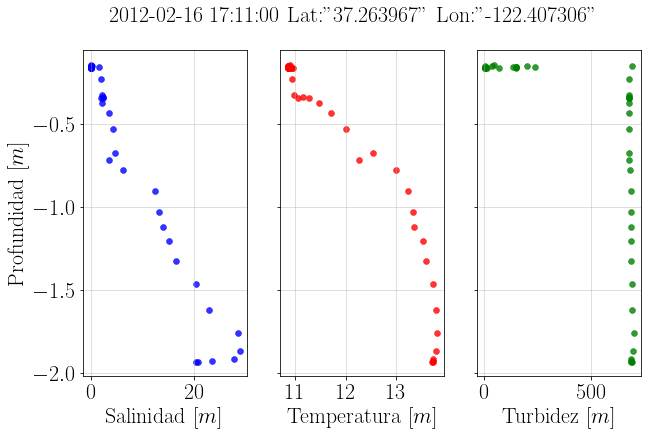

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,10,58):dtz.datetime(2012,2,16,17,11,5)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:11:00 Lat:"37.263967" Lon:"-122.407306"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

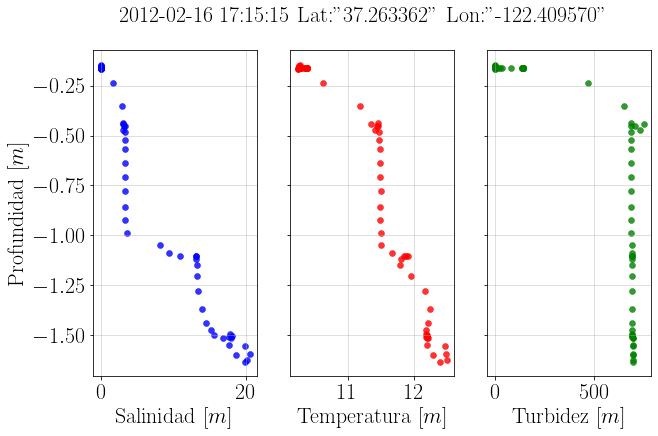

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,15,10):dtz.datetime(2012,2,16,17,15,21)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:15:15 Lat:"37.263362" Lon:"-122.409570"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

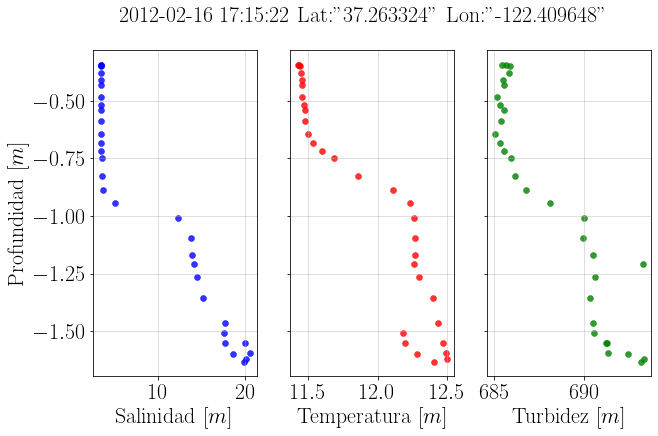

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,15,20):dtz.datetime(2012,2,16,17,15,25)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:15:22 Lat:"37.263324" Lon:"-122.409648"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

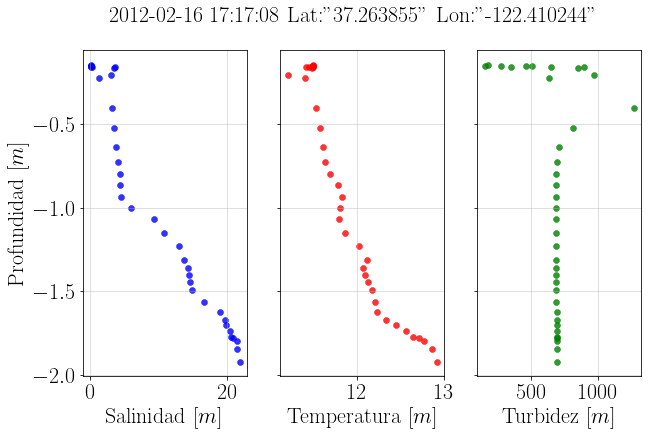

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,17,5):dtz.datetime(2012,2,16,17,17,11)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:17:08 Lat:"37.263855" Lon:"-122.410244"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

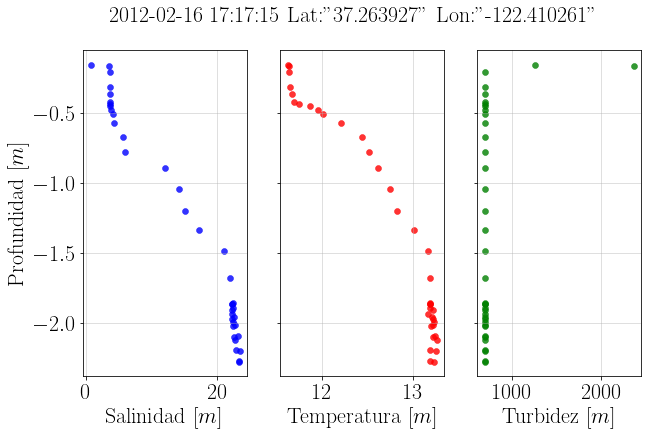

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,17,13):dtz.datetime(2012,2,16,17,17,19)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:17:15 Lat:"37.263927" Lon:"-122.410261"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

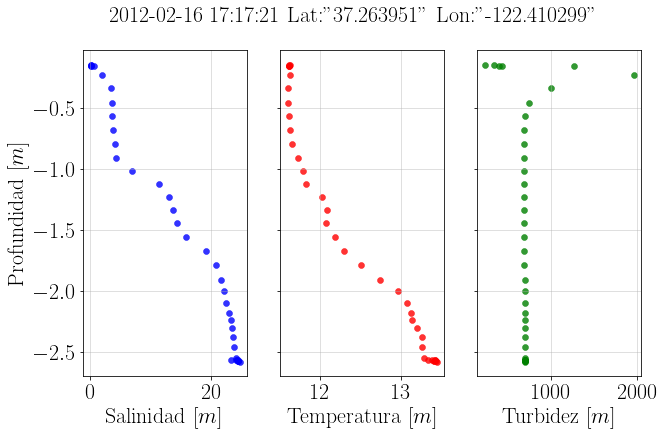

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,17,19):dtz.datetime(2012,2,16,17,17,25)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:17:21 Lat:"37.263951" Lon:"-122.410299"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

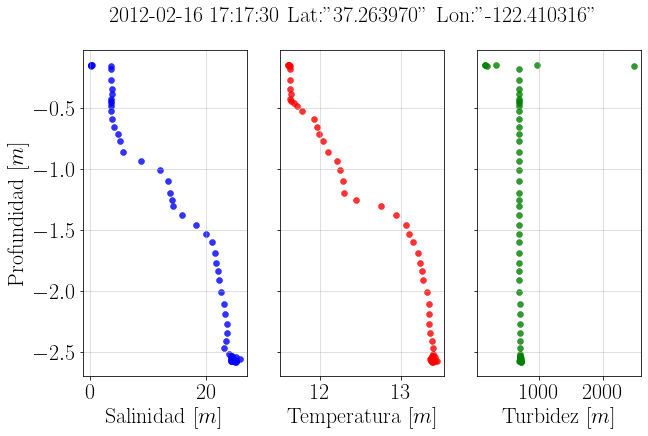

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,17,25):dtz.datetime(2012,2,16,17,17,35)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:17:30 Lat:"37.263970" Lon:"-122.410316"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

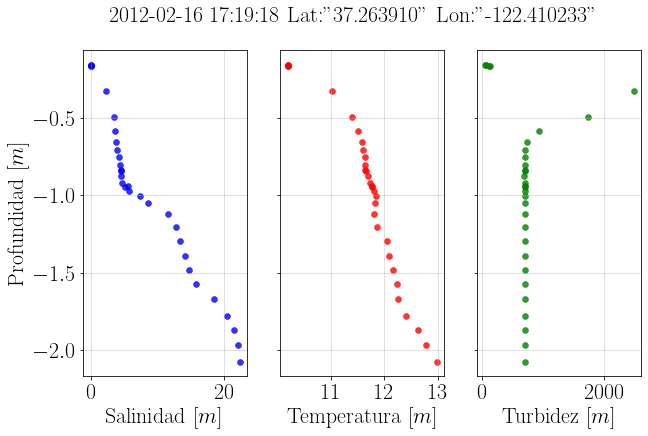

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,19,15):dtz.datetime(2012,2,16,17,19,20)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:19:18 Lat:"37.263910" Lon:"-122.410233"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

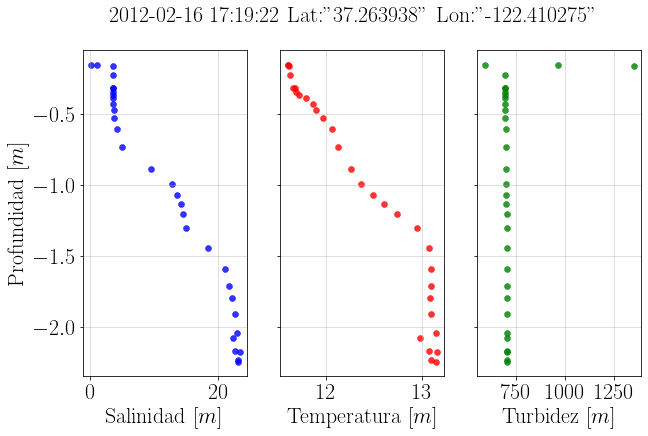

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,19,20):dtz.datetime(2012,2,16,17,19,25)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:19:22 Lat:"37.263938" Lon:"-122.410275"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

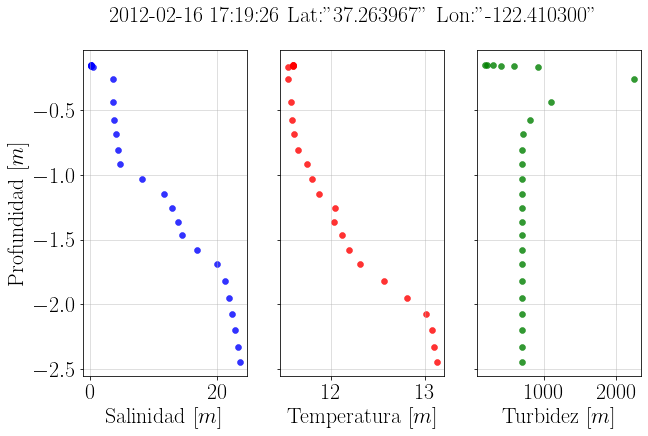

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,19,25):dtz.datetime(2012,2,16,17,19,29)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:19:26 Lat:"37.263967" Lon:"-122.410300"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

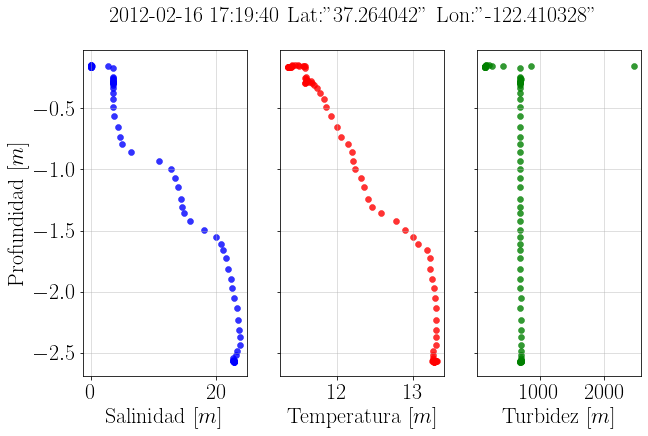

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,19,31):dtz.datetime(2012,2,16,17,19,45)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:19:40 Lat:"37.264042" Lon:"-122.410328"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

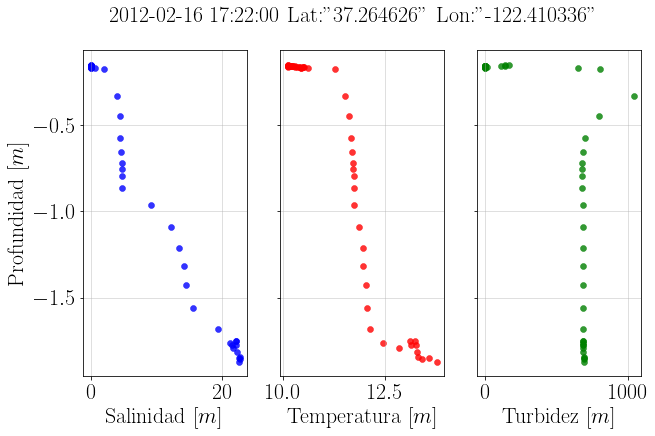

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,21,55):dtz.datetime(2012,2,16,17,22,4)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:22:00 Lat:"37.264626" Lon:"-122.410336"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

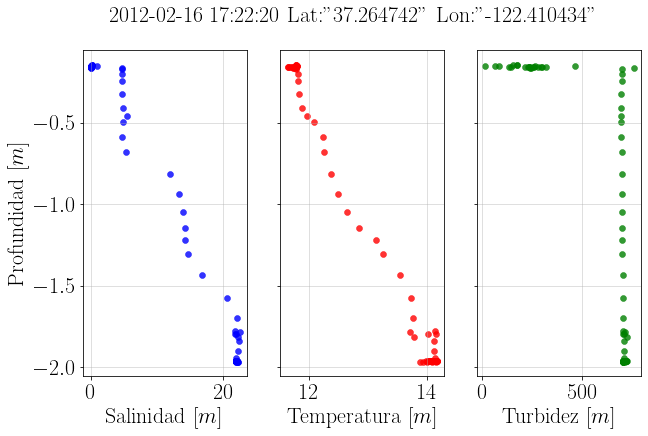

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,22,15):dtz.datetime(2012,2,16,17,22,30)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:22:20 Lat:"37.264742" Lon:"-122.410434"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

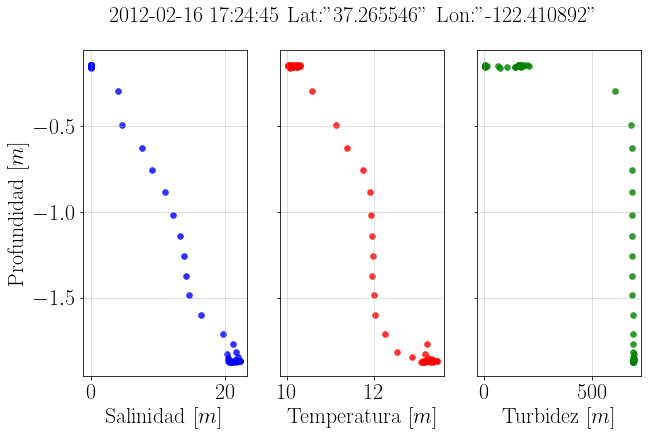

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,24,35):dtz.datetime(2012,2,16,17,24,45)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:24:45 Lat:"37.265546" Lon:"-122.410892"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

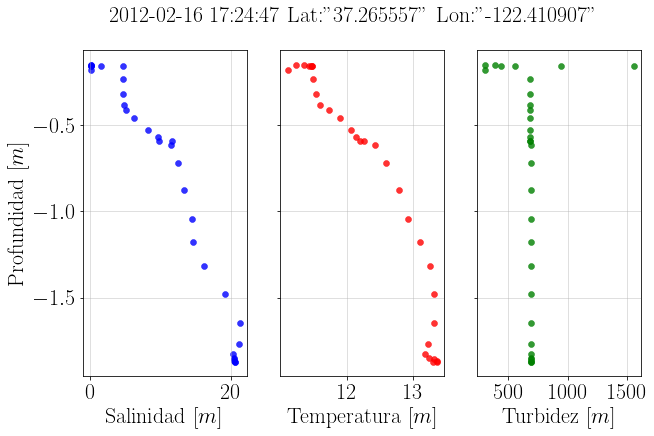

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,24,44):dtz.datetime(2012,2,16,17,24,49)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:24:47 Lat:"37.265557" Lon:"-122.410907"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

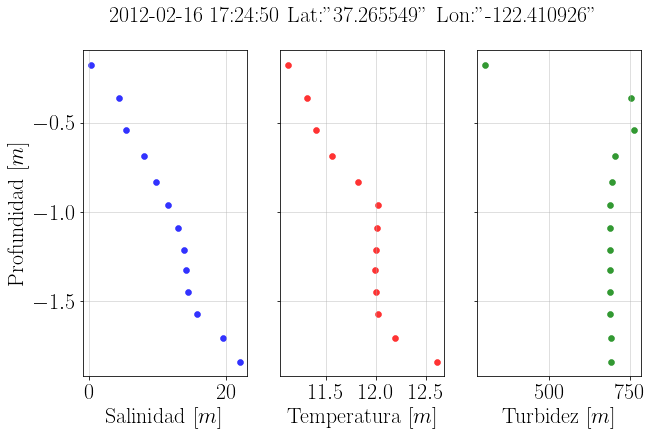

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,24,49):dtz.datetime(2012,2,16,17,24,51)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:24:50 Lat:"37.265549" Lon:"-122.410926"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

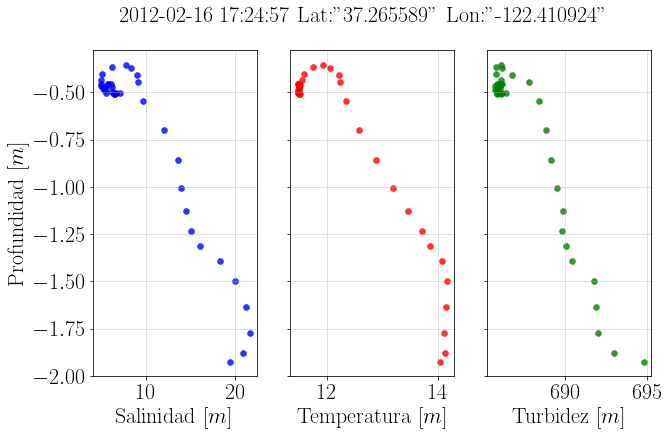

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,24,54):dtz.datetime(2012,2,16,17,25,0)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:24:57 Lat:"37.265589" Lon:"-122.410924"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

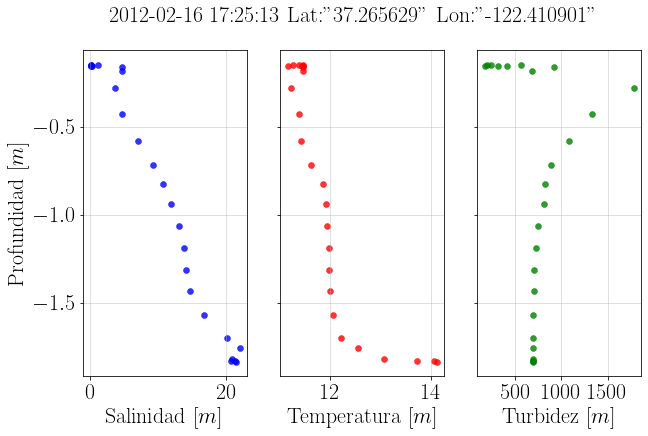

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,25,11):dtz.datetime(2012,2,16,17,25,15)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:25:13 Lat:"37.265629" Lon:"-122.410901"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

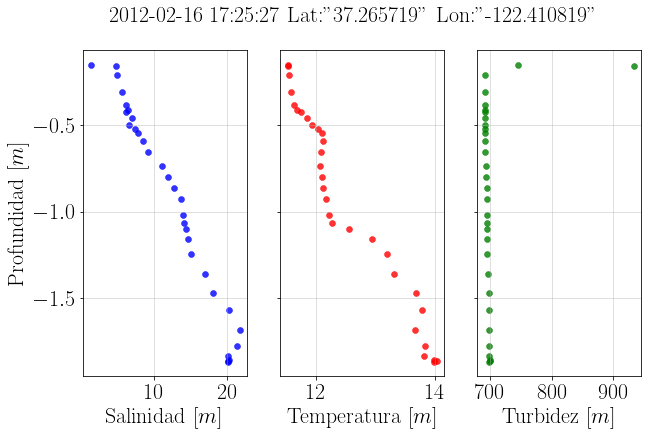

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,25,25):dtz.datetime(2012,2,16,17,25,30)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:25:27 Lat:"37.265719" Lon:"-122.410819"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

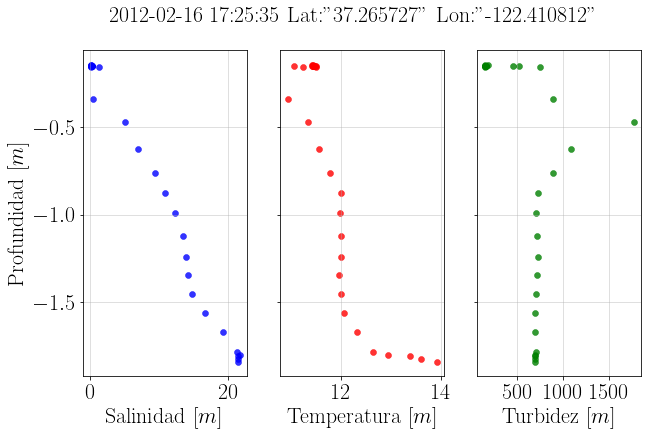

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,25,30):dtz.datetime(2012,2,16,17,25,35)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:25:35 Lat:"37.265727" Lon:"-122.410812"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

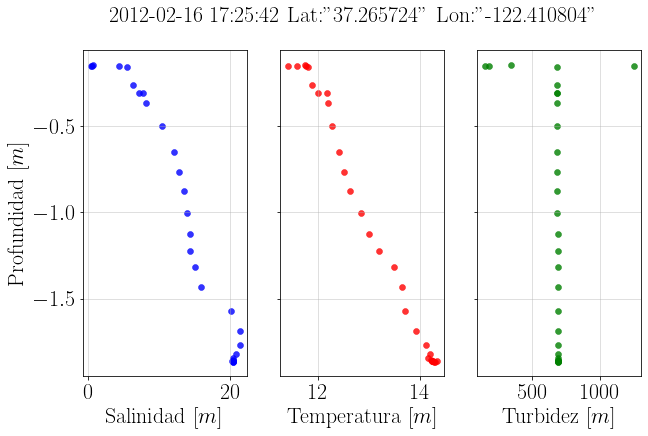

In [ ]:
data_cut = data.loc[dtz.datetime(2012,2,16,17,25,40):dtz.datetime(2012,2,16,17,25,45)]
fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, figsize=(10, 6), sharey=True)

fig.suptitle('2012-02-16 17:25:42 Lat:"37.265724" Lon:"-122.410804"', fontsize=22)
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.set_ylabel(r"Profundidad "
          r"$\displaystyle[m]$",
          fontsize=22)
ax2.set_xlabel(r"Salinidad "
          r"$\displaystyle[m]$",
          fontsize=22)

ax2.scatter(data_cut['Salinity'].values, -data_cut['Depth'].values, c='b', alpha=0.8, linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax3.set_xlabel(r"Temperatura "
          r"$\displaystyle[m]$",
          fontsize=22)

ax3.scatter(data_cut['Temperature'].values, -data_cut['Depth'].values, c='r', alpha=0.8, linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

ax4.set_xlabel(r"Turbidez "
          r"$\displaystyle[m]$",
          fontsize=22)

ax4.scatter(data_cut['Turbidity'].values, -data_cut['Depth'].values, c='g', alpha=0.8, linewidth=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)